This notebook is about how LightGBM and Shapley values can be applied to create powerful and interpretable models in situations with multiplicative (rather than additive) models. A simple, two factor dataset will be generated: age and vehicle type will be used to model (imaginary) insurance claims.

This is a very simple exercise meaning to highlight a couple key areas, so most normal modelling practice (e.g. holdout sets) will be skipped over.

# Imports and settings

In [1]:
from collections import OrderedDict
from lightgbm import LGBMRegressor
from ipywidgets import interact, interactive, interact_manual, fixed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from util import (
    generate_dataset,
    fit_and_plot_model,
)

In [3]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [14, 6]
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 12

In [4]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,lightgbm

CPython 3.7.3
IPython 7.5.0

numpy 1.16.4
pandas 0.24.2
lightgbm 2.2.1

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 69 Stepping 1, GenuineIntel
CPU cores  : 4
interpreter: 64bit


# Dataset and modelling parameters

In [5]:
SAMPLE_SIZE = 10_000
VEHICLES = ["Ferrari", "Motorcycle", "Minivan"]
ADD_INTERACTION = True
MODEL_INTERACTIONS = True
COLORS = ["#fead99", "#456789", "#6699ff"]

colormap = {veh: COLORS[i] for i, veh in enumerate(VEHICLES)}

# Generate dataset

In [6]:
df = generate_dataset(SAMPLE_SIZE, VEHICLES, ADD_INTERACTION)
df.head()

,age,vehicle,true_mean,claim_count
0,40.147794,Ferrari,0.047316,0
1,47.468332,Ferrari,0.020590,0
2,42.521589,Ferrari,0.043156,0
3,39.974860,Motorcycle,0.058749,0
4,34.640811,Minivan,0.020445,0


# EDA

Claims will be relatively rare, making for an imbalanced target variable.

In [7]:
df.claim_count.value_counts().sort_index()

0    9165
1     765
2      66
3       3
4       1
Name: claim_count, dtype: int64

Plot true conditional means against age and vehicle type.

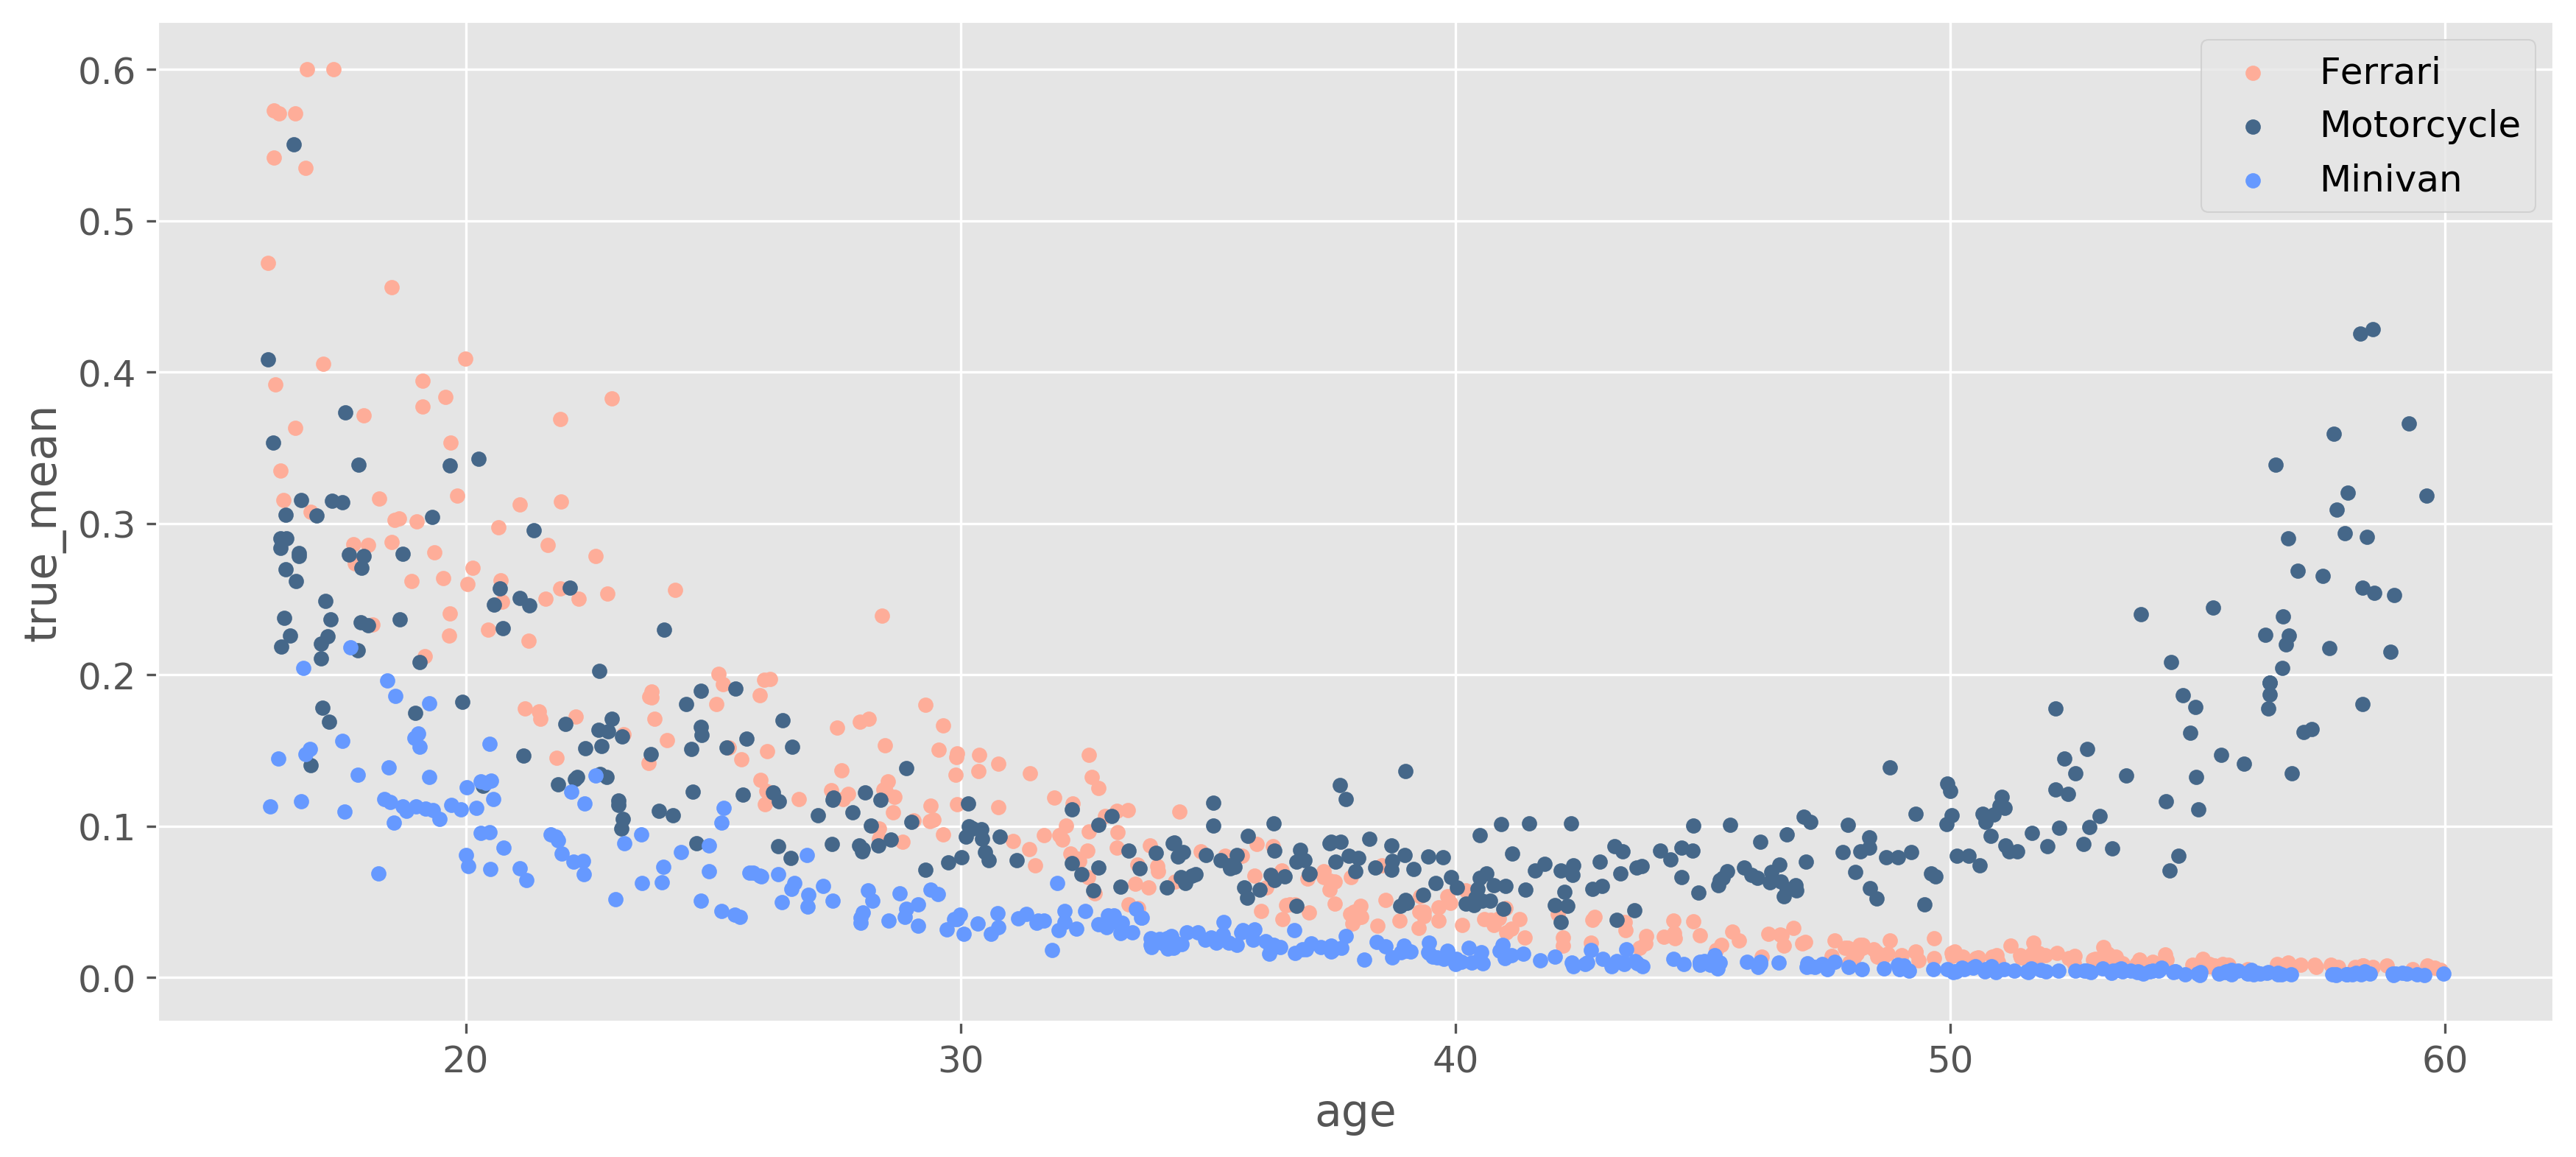

In [8]:
samp = df.sample(1_000)
f, ax = plt.subplots()
for veh in VEHICLES:
    samp[samp.vehicle == veh].plot.scatter(
        "age", "true_mean", label=veh, color=colormap[veh], ax=ax
    )

Plot claims as well (cutting age into bands makes more sense here).

In [9]:
df["age_bands"] = pd.cut(df["age"], bins=range(15, 65, 5))

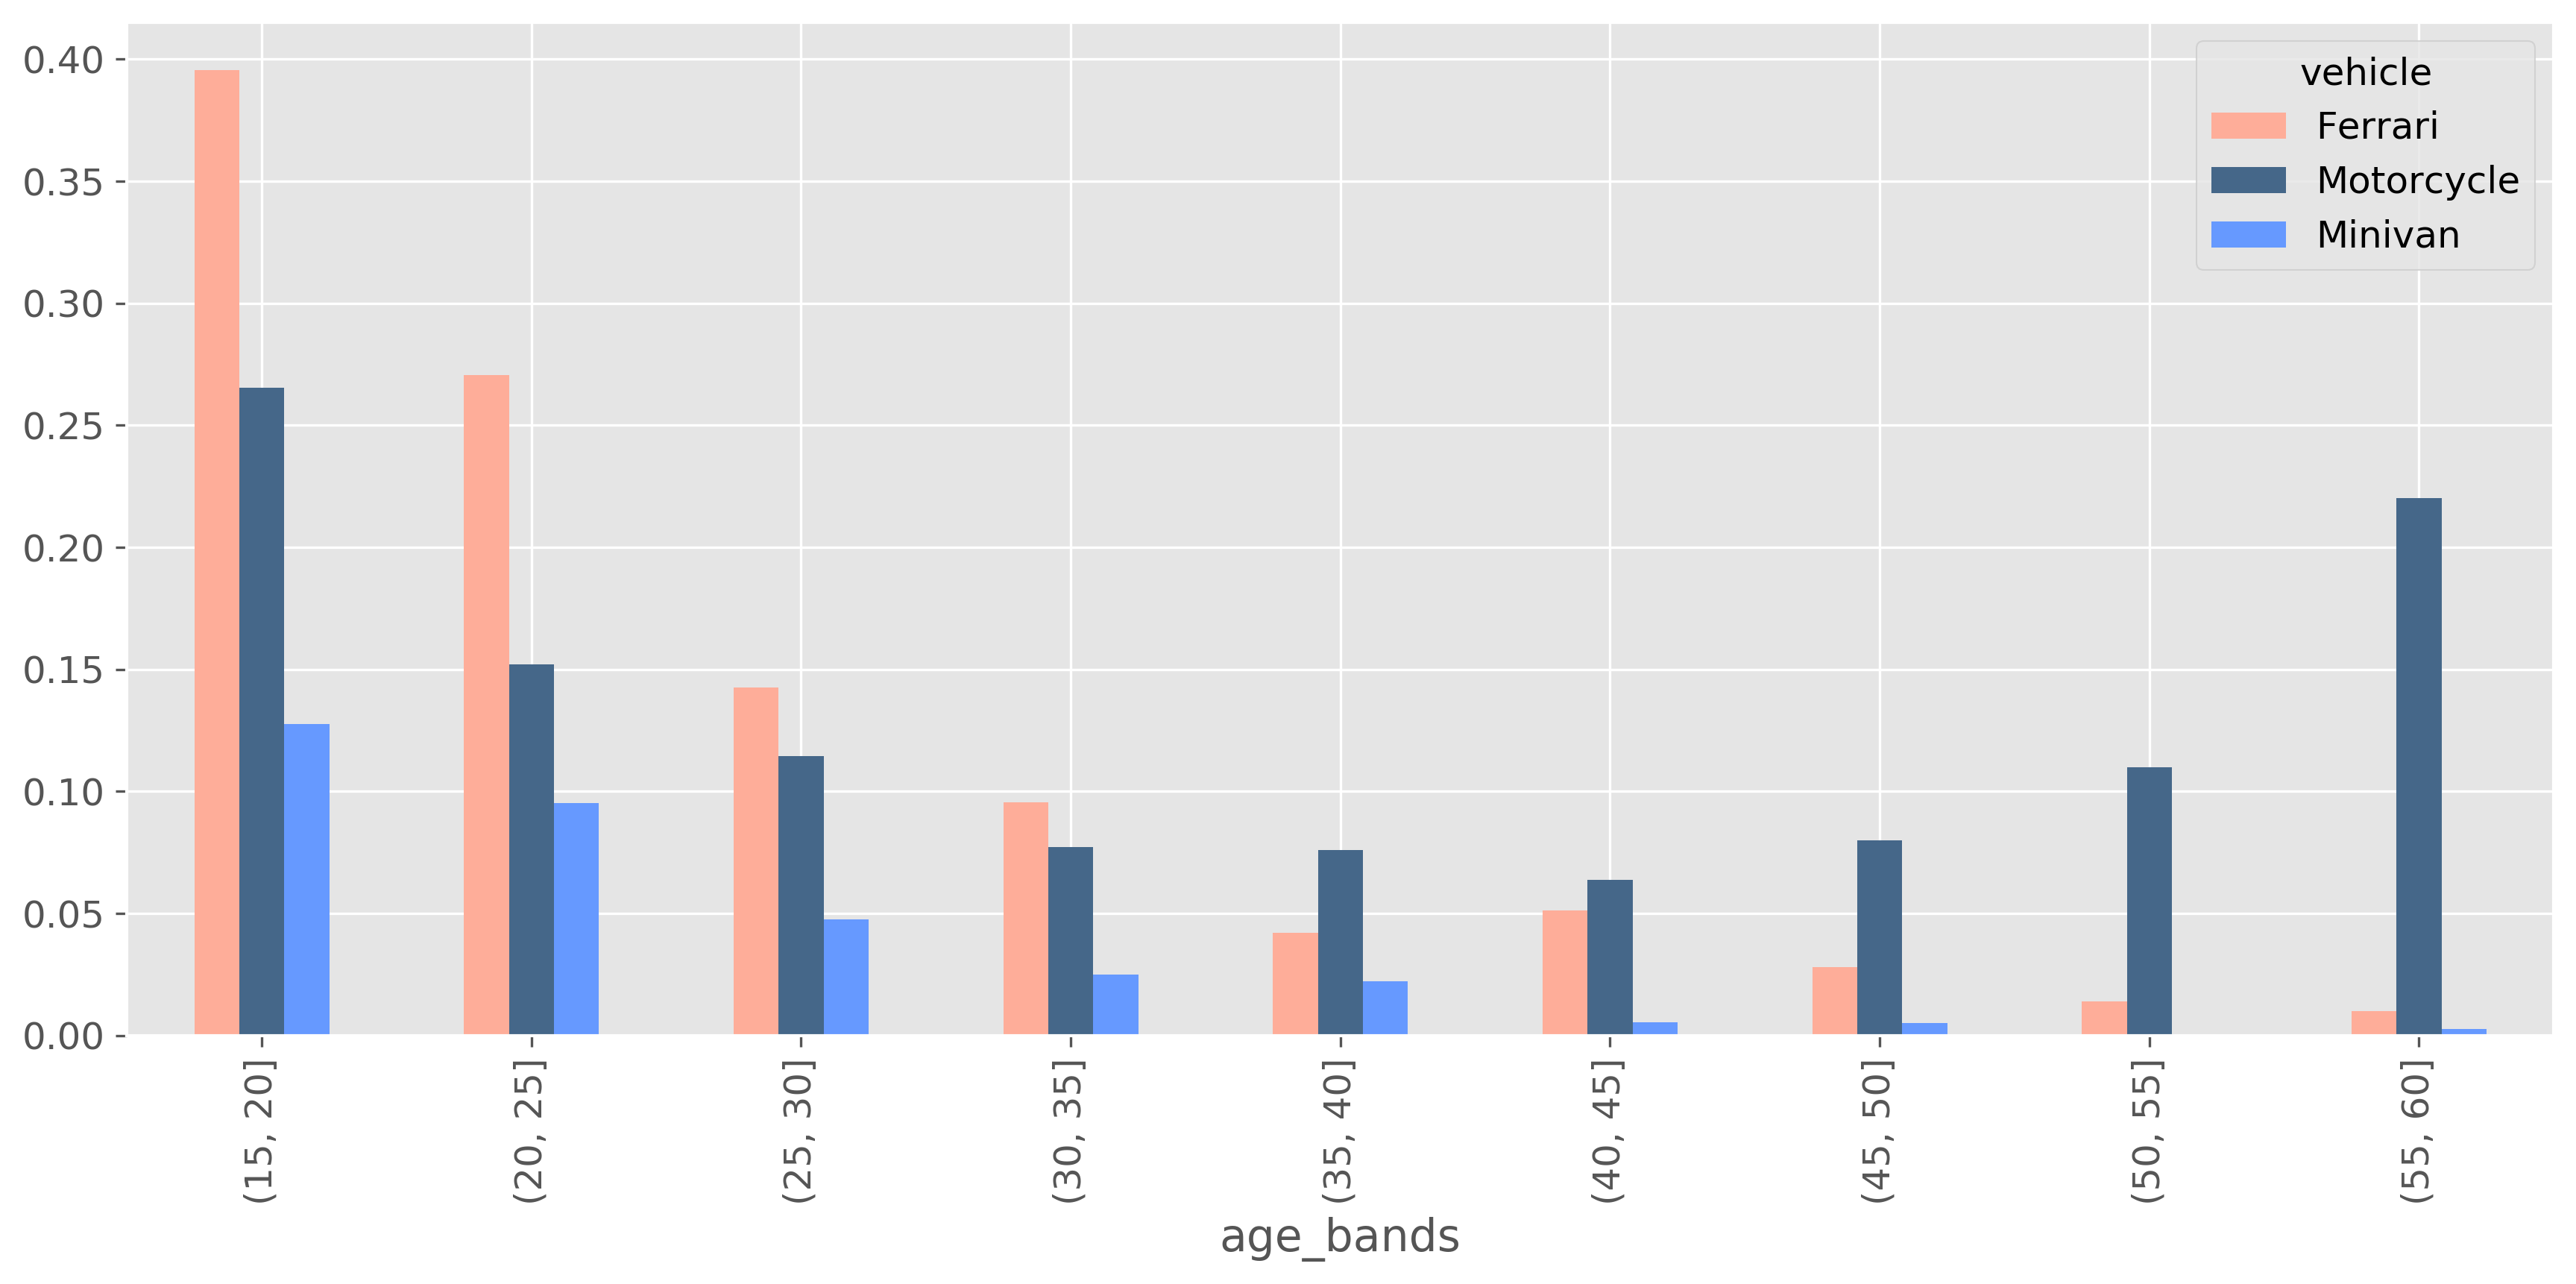

In [10]:
df.groupby(["age_bands", "vehicle"]).claim_count.mean().unstack().plot.bar(color=colormap.values())

# Build a LightGBM poisson model

In [11]:
X = df[["age", "vehicle"]]
y = df["claim_count"]

In [12]:
lgbm = LGBMRegressor(
    objective="poisson",
    max_depth=MODEL_INTERACTIONS + 1,
    n_estimators=80
)

In [13]:
lgbm.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=2,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=80, n_jobs=-1, num_leaves=31, objective='poisson',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Add model predictions to dataframe.

In [14]:
df["pred"] = lgbm.predict(X).round(5)

# Use shap values to calculate relativities

Exporting shap values is built into LightGBM, no need to download the `shap` package.

In [15]:
shap_vals = lgbm.predict(X, pred_contrib=True)

For each observation, calculating $\prod e^{s_{i}}$ for each Shapley value $s_{i}$ will equal the model output:

In [16]:
df["shap_pred"] = np.exp(shap_vals).prod(axis=1).round(5)
assert (df.pred == df.shap_pred).all()

Exponentiating the Shapley values will result in 'relativities' for each factor, i.e. multiplicative adjustments to the model output for that value. The last Shapley value for each observation is a constant 'base rate' which is common across all observations.

In [17]:
for i, col in enumerate(X.columns):
    df[col + "_relativity"] = np.exp(shap_vals[:, i])
    
df["base_rate"] = np.exp(shap_vals[:, -1])

In [18]:
df.head()

,age,vehicle,true_mean,claim_count,age_bands,pred,shap_pred,age_relativity,vehicle_relativity,base_rate
0,40.147794,Ferrari,0.047316,0,"(40, 45]",0.03039,0.03039,0.484084,1.075753,0.058361
1,47.468332,Ferrari,0.020590,0,"(45, 50]",0.03039,0.03039,0.471303,1.104926,0.058361
2,42.521589,Ferrari,0.043156,0,"(40, 45]",0.03039,0.03039,0.481112,1.082399,0.058361
3,39.974860,Motorcycle,0.058749,0,"(35, 40]",0.09178,0.09178,0.644116,2.441503,0.058361
4,34.640811,Minivan,0.020445,0,"(30, 35]",0.02917,0.02917,1.053049,0.474589,0.058361


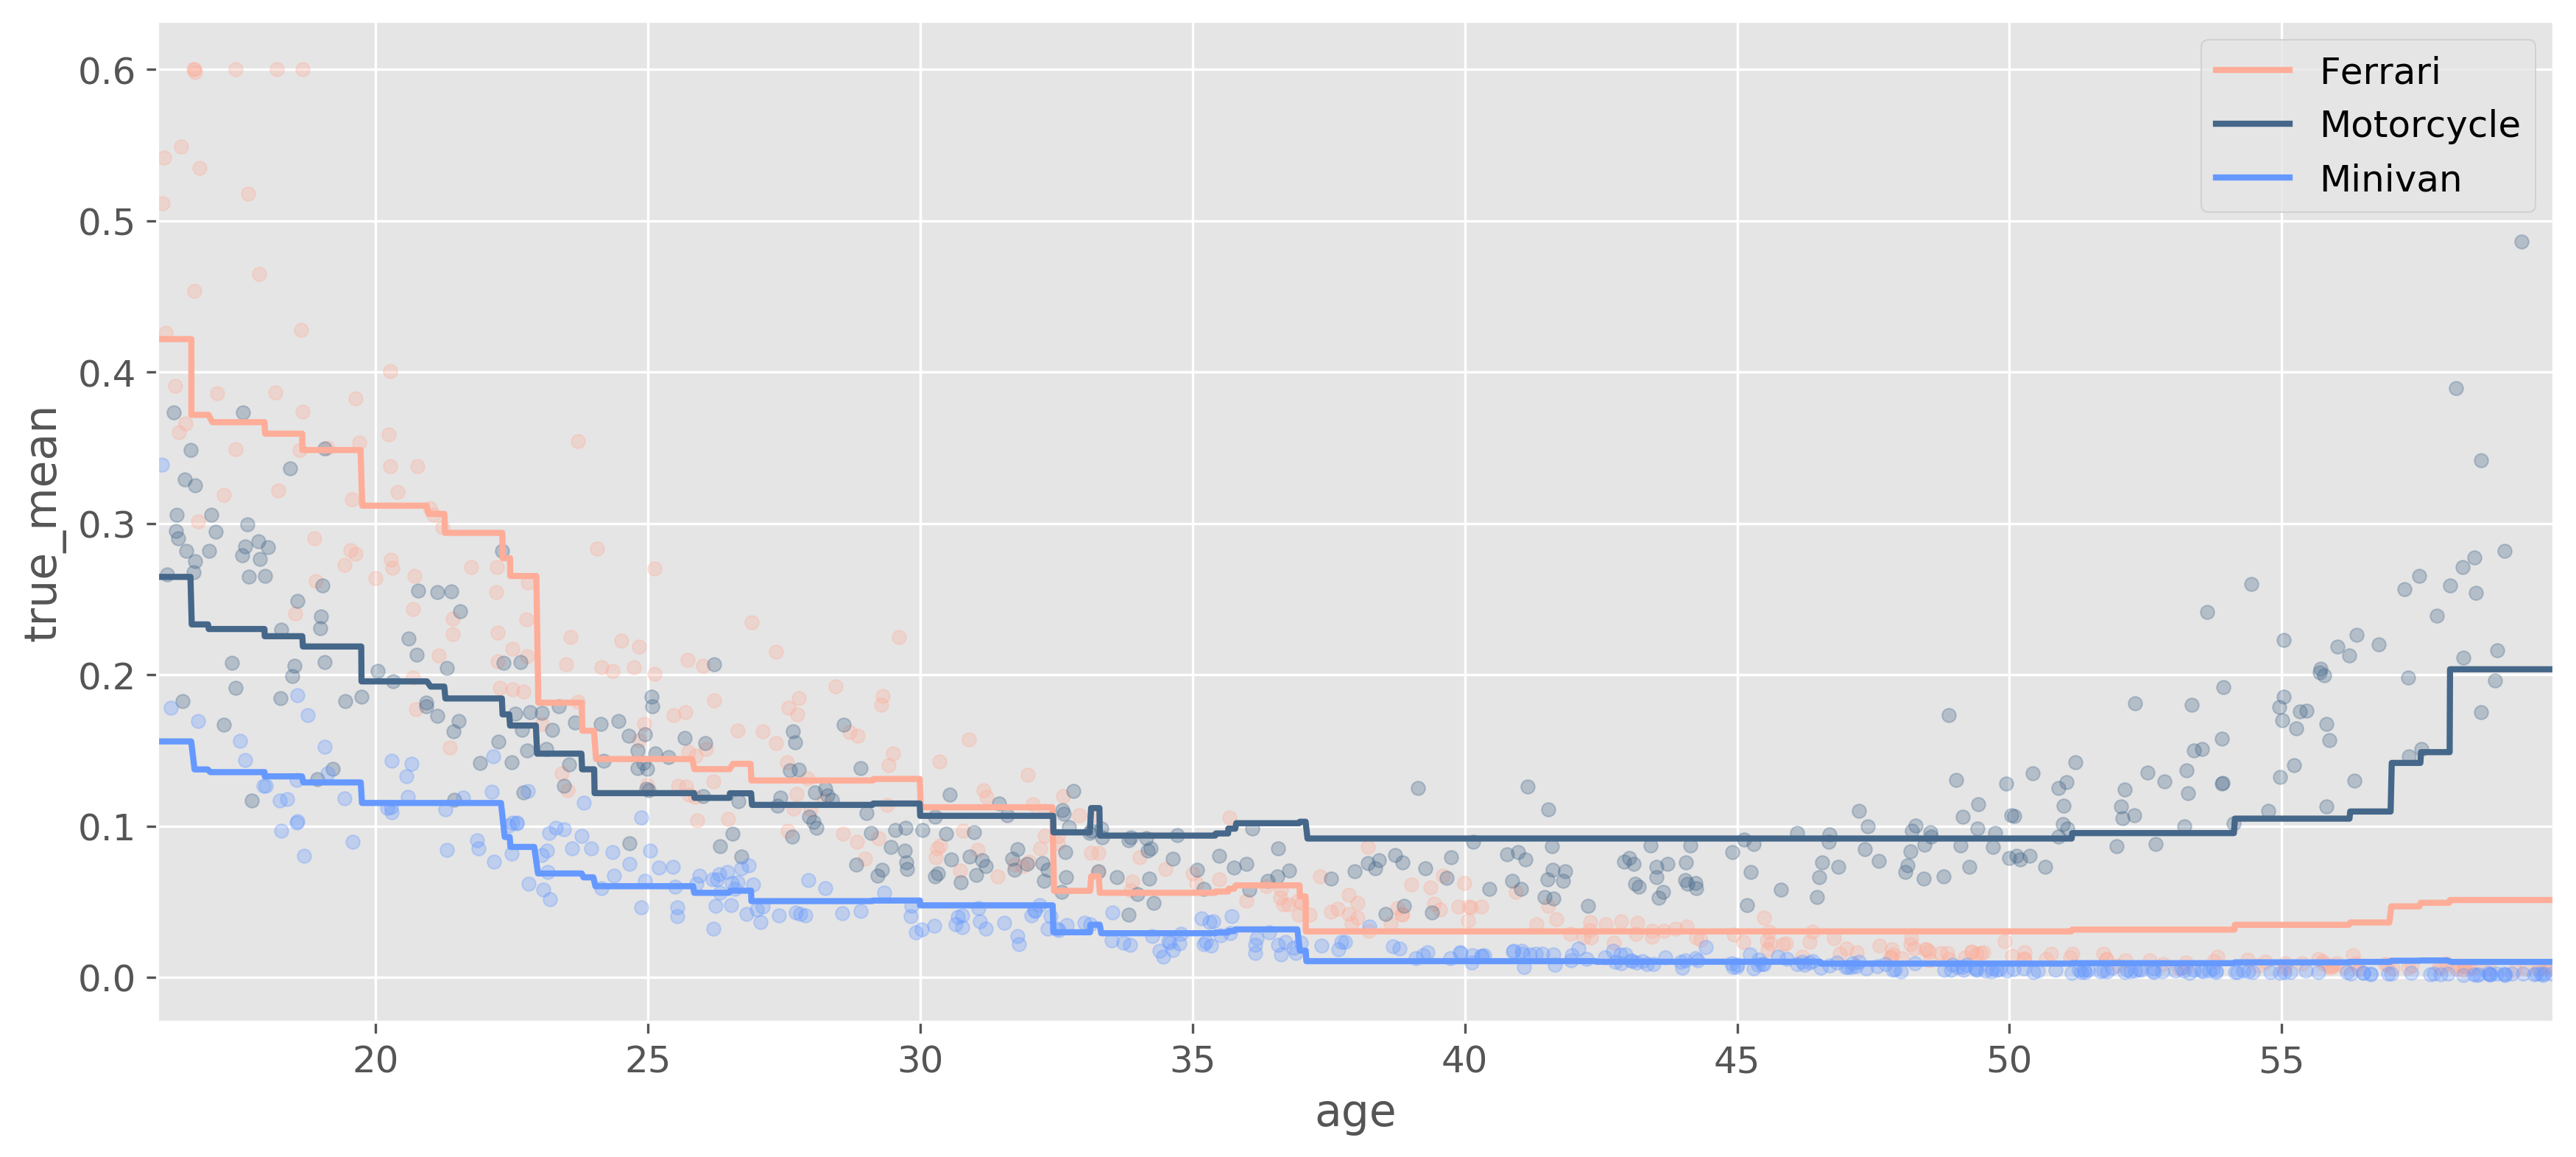

In [19]:
samp = df.sample(1_000)
f, ax = plt.subplots()

for veh in VEHICLES:
    samp[samp.vehicle == veh].plot.scatter(
        "age", "true_mean", color=colormap[veh], ax=ax, alpha=0.3
    )
    tmp = df[df.vehicle == veh].groupby("age").pred.mean()
    tmp.plot(label=veh, color=colormap[veh], linewidth=2, ax=ax)
    
plt.legend()

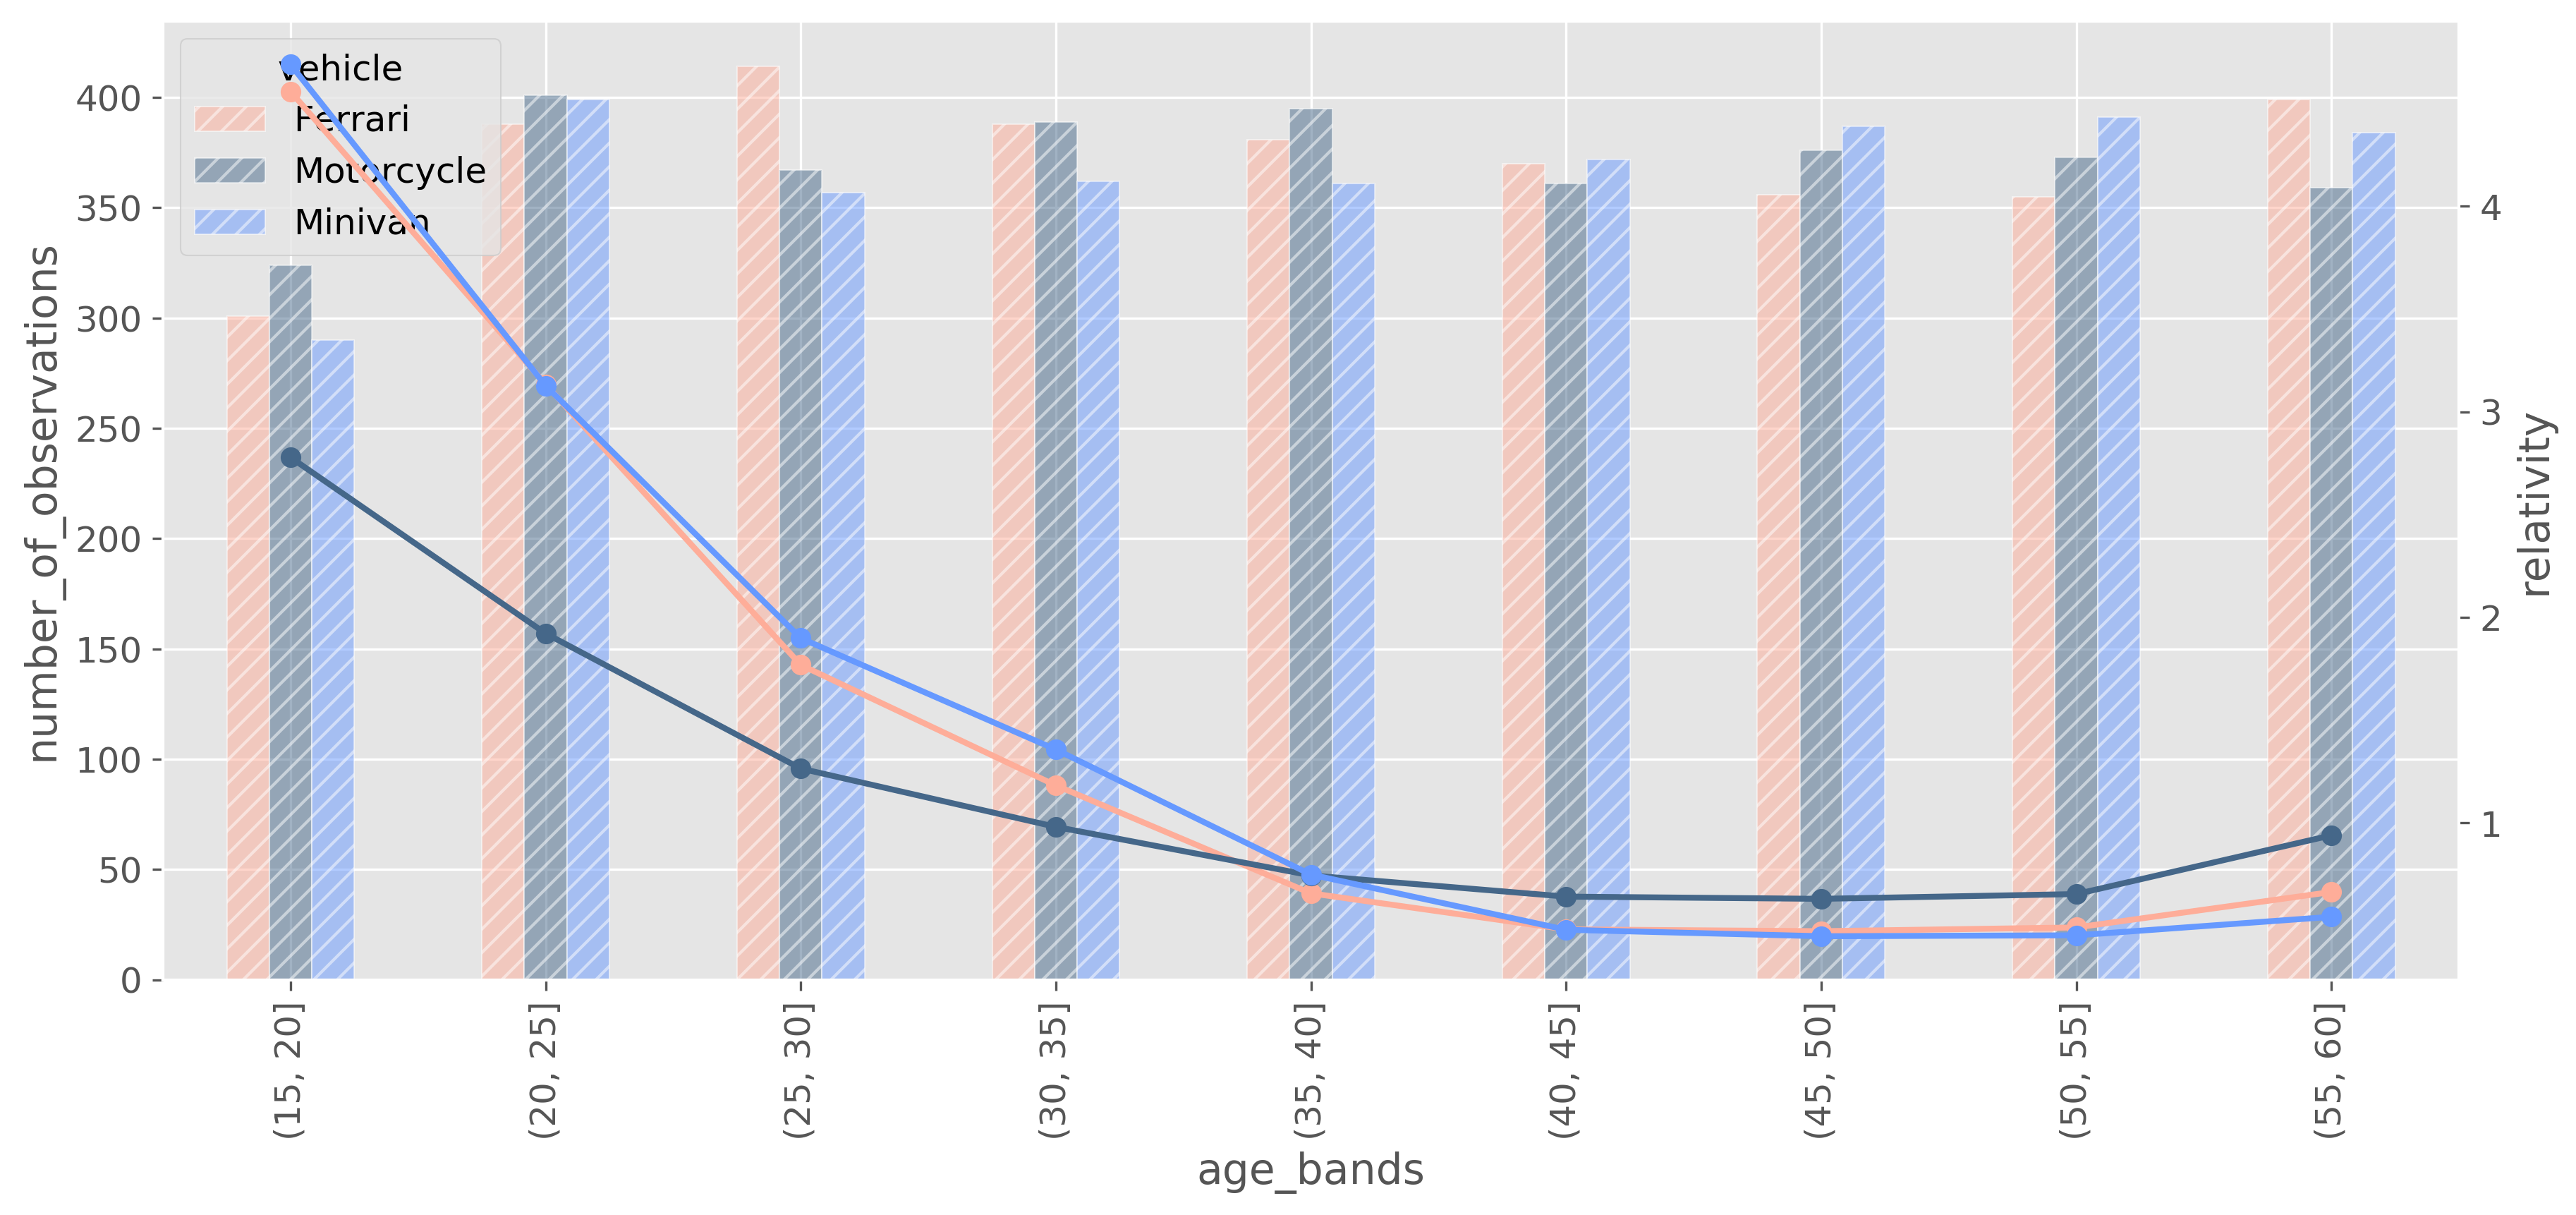

In [20]:
f, ax = plt.subplots()
ax2 = ax.twinx()

su = df.groupby(["age_bands", "vehicle"]).size().unstack()
su.plot.bar(color=colormap.values(), alpha=0.5, edgecolor="white", hatch="///", ax=ax)
ax.set_ylabel("number_of_observations")

for veh in VEHICLES:
    tmp = df[df.vehicle == veh].groupby("age_bands").age_relativity.mean()
    ax2.plot(ax.get_xticks(), tmp, label=veh, color=colormap[veh], linewidth=2)
    ax2.plot(ax.get_xticks(), tmp, label=veh, color=colormap[veh], marker="o")
    ax2.set_ylabel("relativity")
    ax2.grid(False)

These rates could be put into a two-way rating table.

In [21]:
cols = ["base_rate", "vehicle_relativity", "age_relativity"]
df.groupby(["vehicle", "age_bands"])[cols].mean().prod(axis=1)

vehicle     age_bands
Ferrari     (15, 20]     0.368039
            (20, 25]     0.248178
            (25, 30]     0.133996
            (30, 35]     0.081740
            (35, 40]     0.041978
            (40, 45]     0.030392
            (45, 50]     0.030394
            (50, 55]     0.031792
            (55, 60]     0.043822
Motorcycle  (15, 20]     0.232079
            (20, 25]     0.166078
            (25, 30]     0.116603
            (30, 35]     0.101057
            (35, 40]     0.096916
            (40, 45]     0.091780
            (45, 50]     0.091787
            (50, 55]     0.095970
            (55, 60]     0.148295
Minivan     (15, 20]     0.136040
            (20, 25]     0.089850
            (25, 30]     0.053532
            (30, 35]     0.038030
            (35, 40]     0.018240
            (40, 45]     0.010532
            (45, 50]     0.009511
            (50, 55]     0.009431
            (55, 60]     0.010364
dtype: float64

# Interactive model fitting

In [22]:
interact_manual(
    fit_and_plot_model,
    df = fixed(df),
    vehicles = fixed(VEHICLES),
    colormap = fixed(colormap),
    n_estimators=(1, 100, 1),
    n_bands=(2, 50, 1),    
)

interactive(children=(Checkbox(value=True, description='allow_interactions'), IntSlider(value=80, description=…

<function util.fit_and_plot_model(df, vehicles, colormap, allow_interactions=True, n_estimators=80, cut_age_into_bands=False, n_bands=20)>